<a href="https://colab.research.google.com/github/Chaitanyareddynv/Cnarredd_64061/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the dataset



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5199k      0  0:00:15  0:00:15 --:--:-- 10.5M


Data Preparation

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_directory= pathlib.Path("/content/aclImdb")
valid_directory = base_directory/ "val"
training_directory = base_directory / "train"
for category in ("neg", "pos"):
    os.makedirs(valid_directory / category, exist_ok=True )

    files = os.listdir(training_directory / category)
    random.Random(1496).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(training_directory / category / fname,
                    valid_directory / category / fname)

training_data = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
).take(100)

valid_data = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batch_size
).take(10000)
test_data = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = training_data.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

In [3]:
from tensorflow.keras import layers

maximum_len = 150
maximum_tokens = 10000
text_vector = layers.TextVectorization(
    max_tokens=maximum_tokens,
    output_mode="int",
    output_sequence_length=maximum_len,
)
text_vector.adapt(text_only_train_ds)

training_1 = training_data.map(
    lambda x, y: (text_vector(x), y),
    num_parallel_calls=4)
valid_1 = valid_data.map(
    lambda x, y: (text_vector(x), y),
    num_parallel_calls=4)
test_1 = test_data.map(
    lambda x, y: (text_vector(x), y),
    num_parallel_calls=4)

**One-hot encoded vector model**

In [4]:
import tensorflow as tf
input_1 = keras.Input(shape=(None,), dtype="int64")
embedded_layer = tf.one_hot(input_1, depth=maximum_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded_layer)
x = layers.Dropout(0.5)(x)
output_1 = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(input_1, output_1)
model_1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2568513 (9.80 MB)
Trainable params: 2568513 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

Creating a basic understanding of sequencing as a starting point

In [5]:
callbacks_1 = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.x",
                                    save_best_only=True)
]

In [6]:
history_1 = model_1.fit(training_1, validation_data=valid_1, epochs=10, callbacks=callbacks_1)
model_1 = keras.models.load_model("one_hot_bidir_lstm.x")

Epoch 1/10
100/100 [==============================] - 23s 175ms/step - loss: 0.6918 - accuracy: 0.5197 - val_loss: 0.6890 - val_accuracy: 0.5090
Epoch 2/10
100/100 [==============================] - 16s 163ms/step - loss: 0.6322 - accuracy: 0.6547 - val_loss: 0.5483 - val_accuracy: 0.7674
Epoch 3/10
100/100 [==============================] - 16s 160ms/step - loss: 0.4899 - accuracy: 0.7925 - val_loss: 0.4672 - val_accuracy: 0.7956
Epoch 4/10
100/100 [==============================] - 7s 65ms/step - loss: 0.3724 - accuracy: 0.8678 - val_loss: 0.4856 - val_accuracy: 0.7896
Epoch 5/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2994 - accuracy: 0.8991 - val_loss: 0.4708 - val_accuracy: 0.8160
Epoch 6/10
100/100 [==============================] - 9s 87ms/step - loss: 0.2530 - accuracy: 0.9206 - val_loss: 0.4677 - val_accuracy: 0.7960
Epoch 7/10
100/100 [==============================] - 9s 87ms/step - loss: 0.2052 - accuracy: 0.9381 - val_loss: 0.5975 - val_accuracy: 

In [7]:
print(f"Test acc: {model_1.evaluate(test_1)[1]:.3f}")

782/782 [==============================] - 16s 19ms/step - loss: 0.4199 - accuracy: 0.8098
Test acc: 0.810


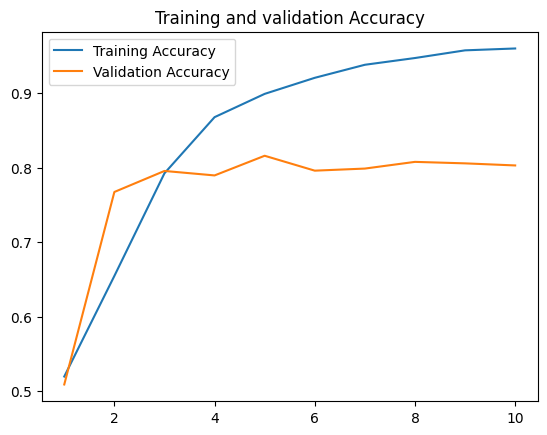

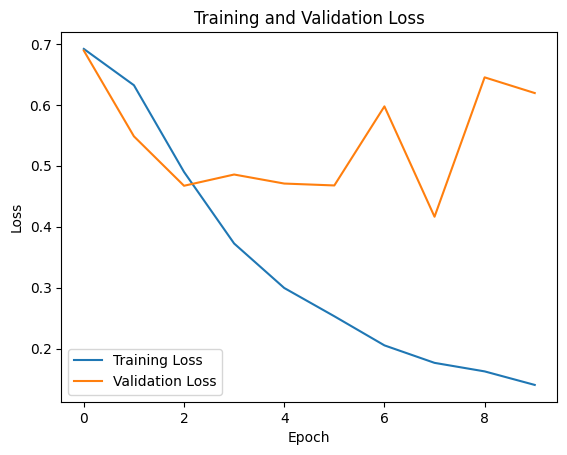

In [8]:
import matplotlib.pyplot as plt

loss = history_1.history["accuracy"]
val_loss = history_1.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label="Training Accuracy")
plt.plot(epochs, val_loss, label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Acquiring embedded words at an embedded level.

Implementing an Anchoring level effectively.

In [9]:
embedding_model = layers.Embedding(input_dim=maximum_tokens, output_dim=256)

The development of the anchor layer system from its inception

In [10]:
input_2 = keras.Input(shape=(None,), dtype="int64")
embedded_2 = layers.Embedding(input_dim=maximum_tokens, output_dim=256)(input_2)
x = layers.Bidirectional(layers.LSTM(32))(embedded_2)
x = layers.Dropout(0.5)(x)
output_2 = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(input_2, output_2)
model_2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_2.summary()

callbacks_2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.x",
                                    save_best_only=True)
]
history_2= model_2.fit(training_1, validation_data=valid_1, epochs=10, callbacks=callbacks_2)
model_2= keras.models.load_model("embeddings_bidir_gru.x")
print(f"Test acc: {model_2.evaluate(test_1)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

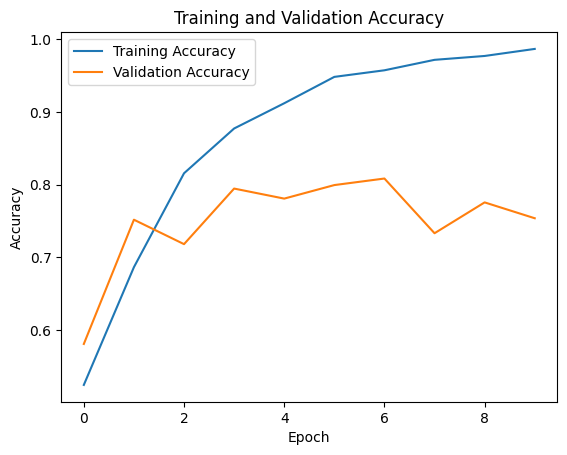

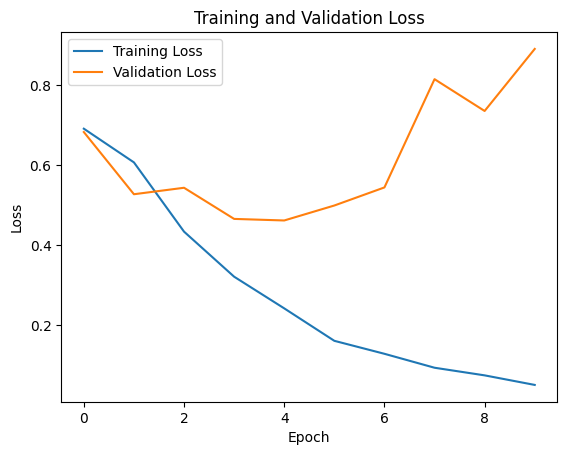

In [11]:

# Plot training and validation accuracy
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Identifying, blurring, and filling in the gaps.

Implementing filtering techniques at the Anchoring level


In [12]:
input_3 = keras.Input(shape=(None,), dtype="int64")
embedded_3 = layers.Embedding(
    input_dim=maximum_tokens, output_dim=256, mask_zero=True)(input_3)
x = layers.Bidirectional(layers.LSTM(32))(embedded_3)
x = layers.Dropout(0.5)(x)
output_3 = layers.Dense(1, activation="sigmoid")(x)
model_3 = keras.Model(input_3, output_3)
model_3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_3.summary()

callbacks_3 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.x",
                                    save_best_only=True)
]
history_3= model_3.fit(training_1, validation_data=valid_1, epochs=10, callbacks=callbacks_3)
model_3 = keras.models.load_model("embeddings_bidir_gru_with_masking.x")
print(f"Test acc: {model_3.evaluate(test_1)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

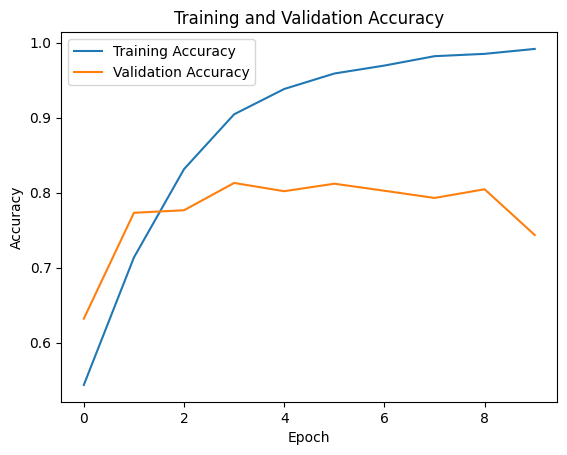

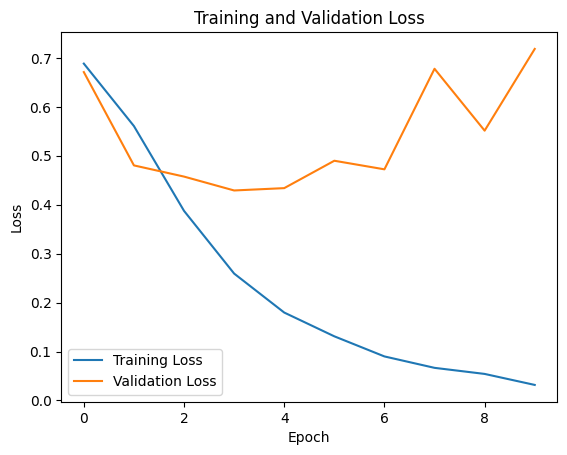

In [13]:
# Plot training and validation accuracy
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Word embeddings that have been preconditioned are utilized

In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-05 22:38:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-05 22:38:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-05 22:38:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Understanding the functionality of the word-embeddings package specifically for "One"

In [15]:
import numpy as np
file_path = "glove.6B.100d.txt"

embedding = {}
with open(file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding[word] = coefs

print(f"Found {len(embedding)} word vectors.")

Found 400000 word vectors.


Preparing the matrix for embedding words from the GloVe website

In [16]:
embed_dimension = 100

vocab = text_vector.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

mat_embed = np.zeros((maximum_tokens, embed_dimension))
for word, i in word_index.items():
    if i < maximum_tokens:
        embedding_vector = embedding.get(word)
    if embedding_vector is not None:
        mat_embed[i] = embedding_vector

In [17]:
embedding_layer_2 = layers.Embedding(
    maximum_tokens,
    embed_dimension,
    embeddings_initializer=keras.initializers.Constant(mat_embed),
    trainable=False,
    mask_zero=True,
)

#The architecture featuring a trained embedded level

In [18]:
input_4 = keras.Input(shape=(None,), dtype="int64")
embedded_4 = embedding_layer_2(input_4)
x = layers.Bidirectional(layers.LSTM(32))(embedded_4)
x = layers.Dropout(0.5)(x)
output_4 = layers.Dense(1, activation="sigmoid")(x)
model_4 = keras.Model(input_4, output_4)
model_4.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model_4.summary()

callbacks_4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.x",
                                    save_best_only=True)
]
history_4=model_4.fit(training_1, validation_data=valid_1, epochs=10, callbacks=callbacks_4)
model_4= keras.models.load_model("glove_embeddings_sequence_model.x")
print(f"Test acc: {model_4.evaluate(test_1)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________

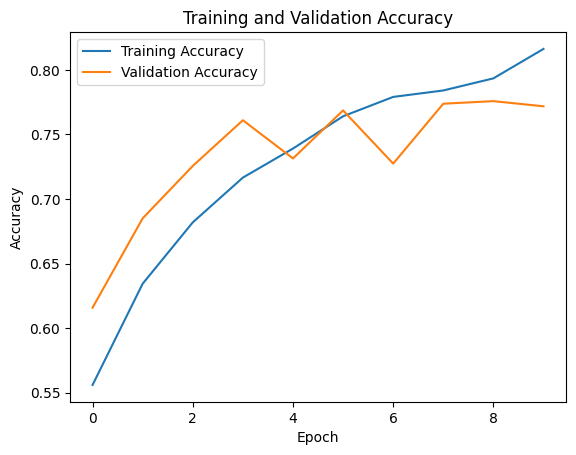

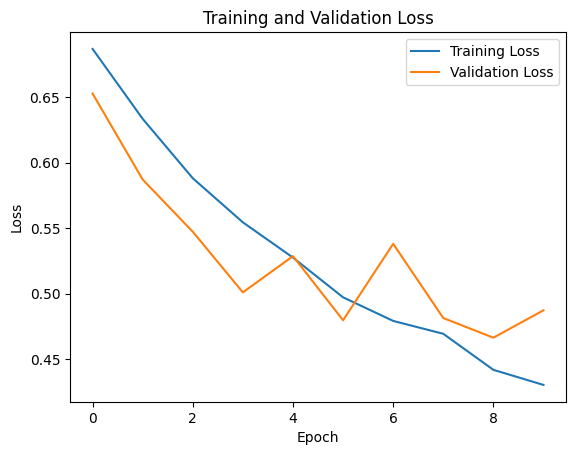

In [19]:
# Plot training and validation accuracy
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_4.history['loss'], label='Training Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 20000 files belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 33s 291ms/step - loss: 0.6924 - accuracy: 0.5300 - val_loss: 0.6901 - val_accuracy: 0.5384
Epoch 2/10
100/100 [==============================] - 29s 291ms/step - loss: 0.6324 - accuracy: 0.6606 - val_loss: 0.5504 - val_accuracy: 0.7520
Epoch 3/10
100/100 [==============================] - 22s 220ms/step - loss: 0.4813 - accuracy: 0.7956 - val_loss: 0.4882 - val_accuracy: 0.7746
Epoch 4/10
100/100 [==============================] - 21s 214ms/step - loss: 0.3487 - accuracy: 0.8650 - val_loss: 0.4459 - val_accuracy: 0.8028
Epoch 5/10
100/100 [==============================] - 8s 80ms/step - loss: 0.2525 - accuracy: 0.9078 - val_loss: 0.4646 - val_accuracy: 0.7914
Epoch 6/10
100/100 [==============================] - 4s 38ms/step - loss: 0.1795 - accuracy: 0.9409 - val_loss: 0.5019 - val_accuracy: 0.7916
Epoch 7/10
100/100 [==============================] - 3s 32ms/step - loss: 0.1368 - accuracy

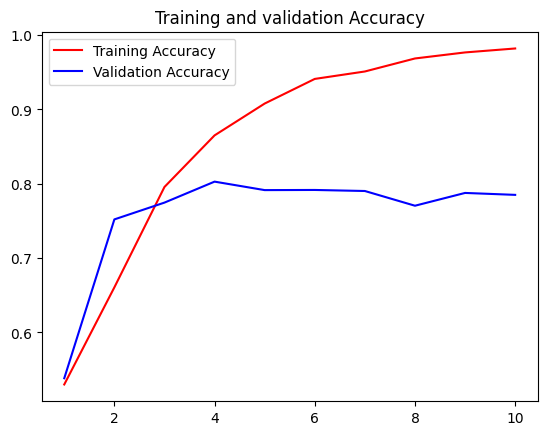

Epoch 1/10
100/100 [==============================] - 44s 346ms/step - loss: 0.6972 - accuracy: 0.5366 - val_loss: 0.6664 - val_accuracy: 0.6086
Epoch 2/10
100/100 [==============================] - 36s 364ms/step - loss: 0.6481 - accuracy: 0.6231 - val_loss: 0.5713 - val_accuracy: 0.7140
Epoch 3/10
100/100 [==============================] - 39s 394ms/step - loss: 0.5858 - accuracy: 0.6922 - val_loss: 0.5532 - val_accuracy: 0.7328
Epoch 4/10
100/100 [==============================] - 5s 51ms/step - loss: 0.5487 - accuracy: 0.7247 - val_loss: 0.7345 - val_accuracy: 0.5936
Epoch 5/10
100/100 [==============================] - 33s 336ms/step - loss: 0.5326 - accuracy: 0.7378 - val_loss: 0.5104 - val_accuracy: 0.7544
Epoch 6/10
100/100 [==============================] - 35s 353ms/step - loss: 0.5086 - accuracy: 0.7491 - val_loss: 0.4966 - val_accuracy: 0.7600
Epoch 7/10
100/100 [==============================] - 33s 337ms/step - loss: 0.4845 - accuracy: 0.7606 - val_loss: 0.4925 - val_accu

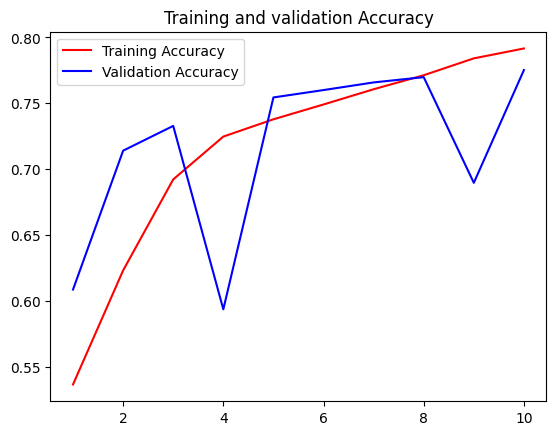

Training samples: 100
Embedding layer test accuracy: 0.801
Pretrained embeddings test accuracy: 0.773
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 58s 98ms/step - loss: 0.5470 - accuracy: 0.7124 - val_loss: 0.5422 - val_accuracy: 0.7388
Epoch 2/10
500/500 [==============================] - 27s 54ms/step - loss: 0.3587 - accuracy: 0.8533 - val_loss: 0.3747 - val_accuracy: 0.8418
Epoch 3/10
500/500 [==============================] - 18s 36ms/step - loss: 0.2943 - accuracy: 0.8829 - val_loss: 0.5038 - val_accuracy: 0.7858
Epoch 4/10
500/500 [==============================] - 19s 38ms/step - loss: 0.2530 - accuracy: 0.9016 - val_loss: 0.3936 - val_accuracy: 0.8428
Epoch 5/10
500/500 [==============================] - 15s 31ms/step - loss: 0.2269 - accuracy: 0.9145 - val_loss: 0.4351 - val_accuracy: 0.8248
Epoch 6/10
500/500 [==============================] - 15s 30ms/step - loss: 0.1960 - 

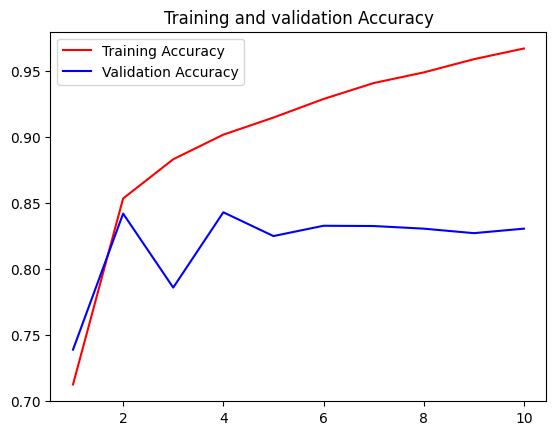

Epoch 1/10
500/500 [==============================] - 62s 106ms/step - loss: 0.6209 - accuracy: 0.6512 - val_loss: 0.5351 - val_accuracy: 0.7332
Epoch 2/10
500/500 [==============================] - 43s 85ms/step - loss: 0.5081 - accuracy: 0.7570 - val_loss: 0.4466 - val_accuracy: 0.7934
Epoch 3/10
500/500 [==============================] - 47s 95ms/step - loss: 0.4571 - accuracy: 0.7852 - val_loss: 0.4365 - val_accuracy: 0.7964
Epoch 4/10
500/500 [==============================] - 20s 40ms/step - loss: 0.4250 - accuracy: 0.8064 - val_loss: 0.4455 - val_accuracy: 0.7882
Epoch 5/10
500/500 [==============================] - 52s 103ms/step - loss: 0.4079 - accuracy: 0.8144 - val_loss: 0.4081 - val_accuracy: 0.8174
Epoch 6/10
500/500 [==============================] - 55s 110ms/step - loss: 0.3880 - accuracy: 0.8253 - val_loss: 0.3953 - val_accuracy: 0.8258
Epoch 7/10
500/500 [==============================] - 24s 48ms/step - loss: 0.3704 - accuracy: 0.8354 - val_loss: 0.4022 - val_accura

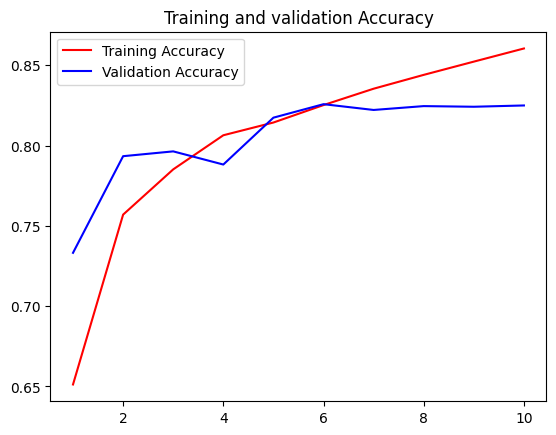

Training samples: 500
Embedding layer test accuracy: 0.831
Pretrained embeddings test accuracy: 0.825
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 54s 77ms/step - loss: 0.5281 - accuracy: 0.7315 - val_loss: 0.3772 - val_accuracy: 0.8336
Epoch 2/10
625/625 [==============================] - 33s 53ms/step - loss: 0.3537 - accuracy: 0.8544 - val_loss: 0.3699 - val_accuracy: 0.8392
Epoch 3/10
625/625 [==============================] - 19s 30ms/step - loss: 0.2959 - accuracy: 0.8820 - val_loss: 0.4181 - val_accuracy: 0.8202
Epoch 4/10
625/625 [==============================] - 26s 42ms/step - loss: 0.2594 - accuracy: 0.8989 - val_loss: 0.3891 - val_accuracy: 0.8392
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 0.2325 - accuracy: 0.9129 - val_loss: 0.4040 - val_accuracy: 0.8328
Epoch 6/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2069 - 

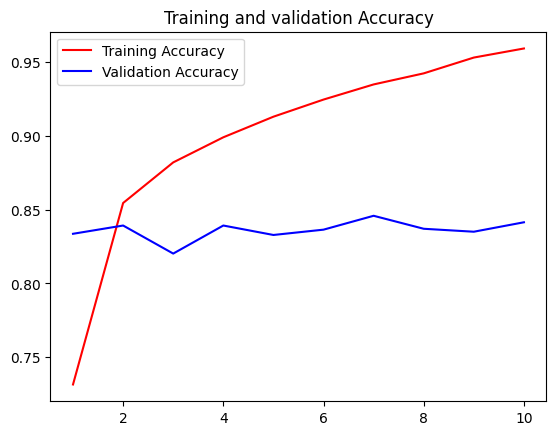

Epoch 1/10
625/625 [==============================] - 71s 101ms/step - loss: 0.6039 - accuracy: 0.6672 - val_loss: 0.5033 - val_accuracy: 0.7586
Epoch 2/10
625/625 [==============================] - 53s 85ms/step - loss: 0.4869 - accuracy: 0.7700 - val_loss: 0.4461 - val_accuracy: 0.7940
Epoch 3/10
625/625 [==============================] - 56s 90ms/step - loss: 0.4407 - accuracy: 0.7952 - val_loss: 0.4388 - val_accuracy: 0.7968
Epoch 4/10
625/625 [==============================] - 53s 85ms/step - loss: 0.4153 - accuracy: 0.8094 - val_loss: 0.4041 - val_accuracy: 0.8168
Epoch 5/10
625/625 [==============================] - 21s 33ms/step - loss: 0.3957 - accuracy: 0.8231 - val_loss: 0.4122 - val_accuracy: 0.8084
Epoch 6/10
625/625 [==============================] - 54s 86ms/step - loss: 0.3782 - accuracy: 0.8324 - val_loss: 0.3963 - val_accuracy: 0.8182
Epoch 7/10
625/625 [==============================] - 26s 42ms/step - loss: 0.3651 - accuracy: 0.8413 - val_loss: 0.4308 - val_accuracy

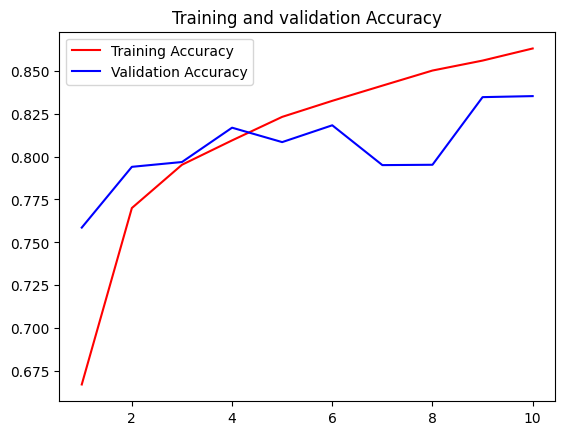

Training samples: 1000
Embedding layer test accuracy: 0.829
Pretrained embeddings test accuracy: 0.833
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 56s 80ms/step - loss: 0.5140 - accuracy: 0.7404 - val_loss: 0.4050 - val_accuracy: 0.8194
Epoch 2/10
625/625 [==============================] - 30s 47ms/step - loss: 0.3470 - accuracy: 0.8589 - val_loss: 0.3673 - val_accuracy: 0.8316
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2913 - accuracy: 0.8845 - val_loss: 0.3888 - val_accuracy: 0.8316
Epoch 4/10
625/625 [==============================] - 20s 33ms/step - loss: 0.2557 - accuracy: 0.9014 - val_loss: 0.3930 - val_accuracy: 0.8378
Epoch 5/10
625/625 [==============================] - 13s 22ms/step - loss: 0.2238 - accuracy: 0.9157 - val_loss: 0.5334 - val_accuracy: 0.8002
Epoch 6/10
625/625 [==============================] - 23s 36ms/step - loss: 0.1962 -

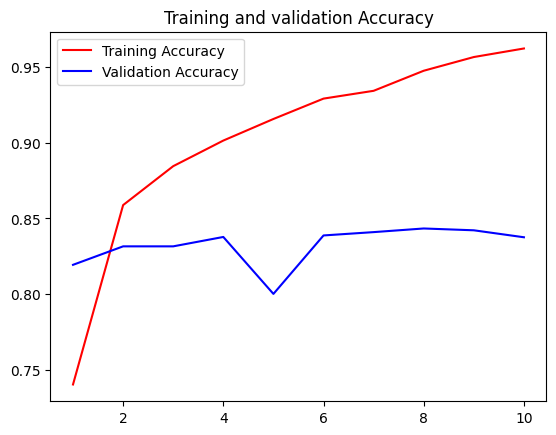

Epoch 1/10
625/625 [==============================] - 72s 100ms/step - loss: 0.5841 - accuracy: 0.6876 - val_loss: 0.4821 - val_accuracy: 0.7628
Epoch 2/10
625/625 [==============================] - 49s 78ms/step - loss: 0.4744 - accuracy: 0.7789 - val_loss: 0.4364 - val_accuracy: 0.7932
Epoch 3/10
625/625 [==============================] - 48s 77ms/step - loss: 0.4335 - accuracy: 0.7997 - val_loss: 0.4255 - val_accuracy: 0.7994
Epoch 4/10
625/625 [==============================] - 47s 76ms/step - loss: 0.4110 - accuracy: 0.8138 - val_loss: 0.4074 - val_accuracy: 0.8152
Epoch 5/10
625/625 [==============================] - 28s 45ms/step - loss: 0.3899 - accuracy: 0.8244 - val_loss: 0.4078 - val_accuracy: 0.8180
Epoch 6/10
625/625 [==============================] - 49s 78ms/step - loss: 0.3721 - accuracy: 0.8332 - val_loss: 0.3908 - val_accuracy: 0.8260
Epoch 7/10
625/625 [==============================] - 56s 89ms/step - loss: 0.3580 - accuracy: 0.8440 - val_loss: 0.3796 - val_accuracy

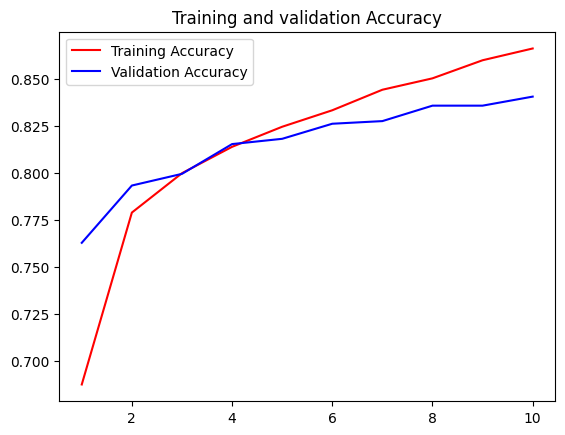

Training samples: 5000
Embedding layer test accuracy: 0.832
Pretrained embeddings test accuracy: 0.837
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 46s 67ms/step - loss: 0.5344 - accuracy: 0.7253 - val_loss: 0.3867 - val_accuracy: 0.8318
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.3507 - accuracy: 0.8569 - val_loss: 0.3584 - val_accuracy: 0.8446
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2967 - accuracy: 0.8834 - val_loss: 0.3973 - val_accuracy: 0.8512
Epoch 4/10
625/625 [==============================] - 16s 25ms/step - loss: 0.2550 - accuracy: 0.9018 - val_loss: 0.3715 - val_accuracy: 0.8396
Epoch 5/10
625/625 [==============================] - 21s 33ms/step - loss: 0.2226 - accuracy: 0.9176 - val_loss: 0.3890 - val_accuracy: 0.8464
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 0.2002 -

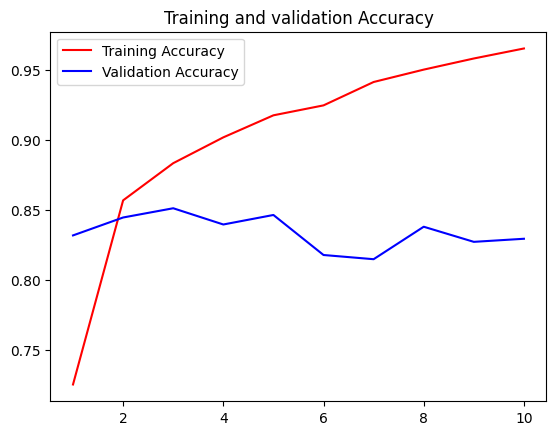

Epoch 1/10
625/625 [==============================] - 63s 78ms/step - loss: 0.5924 - accuracy: 0.6811 - val_loss: 0.4904 - val_accuracy: 0.7662
Epoch 2/10
625/625 [==============================] - 47s 75ms/step - loss: 0.4881 - accuracy: 0.7688 - val_loss: 0.4661 - val_accuracy: 0.7950
Epoch 3/10
625/625 [==============================] - 47s 75ms/step - loss: 0.4435 - accuracy: 0.7962 - val_loss: 0.4180 - val_accuracy: 0.8082
Epoch 4/10
625/625 [==============================] - 47s 75ms/step - loss: 0.4111 - accuracy: 0.8123 - val_loss: 0.3968 - val_accuracy: 0.8206
Epoch 5/10
625/625 [==============================] - 52s 83ms/step - loss: 0.3875 - accuracy: 0.8274 - val_loss: 0.3880 - val_accuracy: 0.8248
Epoch 6/10
625/625 [==============================] - 49s 78ms/step - loss: 0.3685 - accuracy: 0.8377 - val_loss: 0.3712 - val_accuracy: 0.8392
Epoch 7/10
625/625 [==============================] - 18s 28ms/step - loss: 0.3550 - accuracy: 0.8463 - val_loss: 0.3792 - val_accuracy:

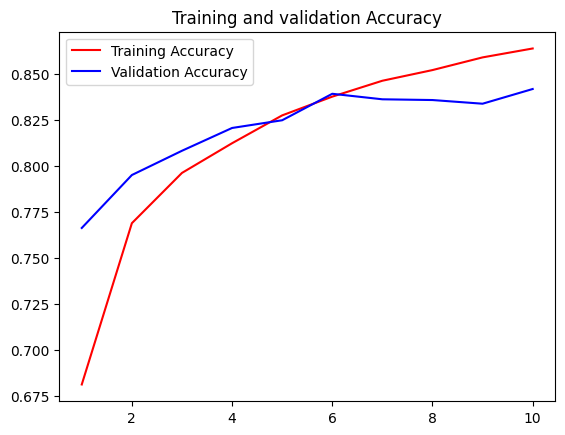

Training samples: 10000
Embedding layer test accuracy: 0.834
Pretrained embeddings test accuracy: 0.837
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 51s 77ms/step - loss: 0.5251 - accuracy: 0.7340 - val_loss: 0.3848 - val_accuracy: 0.8362
Epoch 2/10
625/625 [==============================] - 20s 31ms/step - loss: 0.3533 - accuracy: 0.8562 - val_loss: 0.4233 - val_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 29s 47ms/step - loss: 0.2910 - accuracy: 0.8849 - val_loss: 0.3773 - val_accuracy: 0.8490
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2554 - accuracy: 0.9015 - val_loss: 0.4306 - val_accuracy: 0.8316
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 0.2311 - accuracy: 0.9132 - val_loss: 0.4683 - val_accuracy: 0.8444
Epoch 6/10
625/625 [==============================] - 20s 33ms/step - loss: 0.2060 

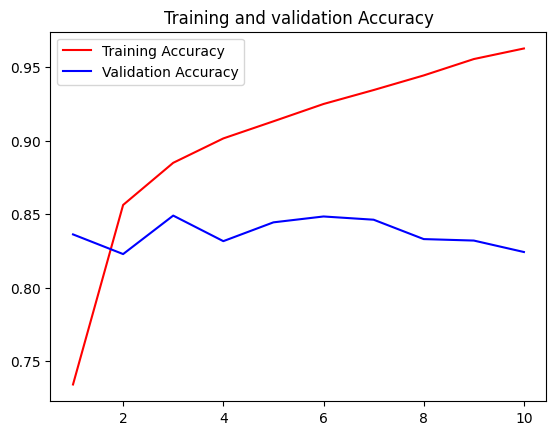

Epoch 1/10
625/625 [==============================] - 68s 91ms/step - loss: 0.5950 - accuracy: 0.6735 - val_loss: 0.5456 - val_accuracy: 0.7306
Epoch 2/10
625/625 [==============================] - 52s 84ms/step - loss: 0.4821 - accuracy: 0.7739 - val_loss: 0.4386 - val_accuracy: 0.8008
Epoch 3/10
625/625 [==============================] - 48s 76ms/step - loss: 0.4434 - accuracy: 0.7943 - val_loss: 0.4253 - val_accuracy: 0.8074
Epoch 4/10
625/625 [==============================] - 52s 83ms/step - loss: 0.4168 - accuracy: 0.8121 - val_loss: 0.4096 - val_accuracy: 0.8078
Epoch 5/10
625/625 [==============================] - 47s 76ms/step - loss: 0.3942 - accuracy: 0.8235 - val_loss: 0.3930 - val_accuracy: 0.8236
Epoch 6/10
625/625 [==============================] - 21s 34ms/step - loss: 0.3779 - accuracy: 0.8290 - val_loss: 0.3997 - val_accuracy: 0.8184
Epoch 7/10
625/625 [==============================] - 51s 82ms/step - loss: 0.3626 - accuracy: 0.8419 - val_loss: 0.3874 - val_accuracy:

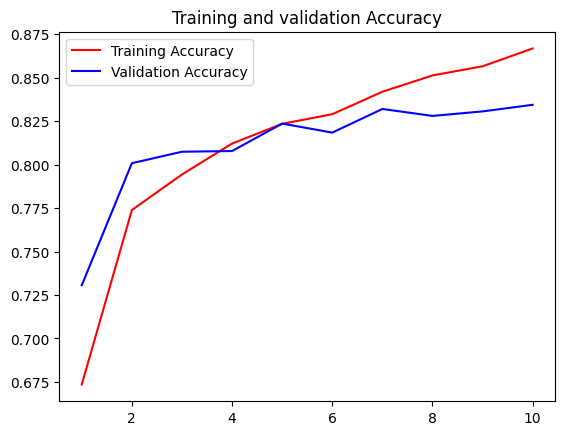

Training samples: 20000
Embedding layer test accuracy: 0.839
Pretrained embeddings test accuracy: 0.831
--------------------------------------------------


In [20]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (text_vector(x), y),
        num_parallel_calls=4
    )
    int_val_ds = valid_data.map(
        lambda x, y: (text_vector(x), y),
        num_parallel_calls=4
    )
    int_test_ds = test_data.map(
        lambda x, y: (text_vector(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(maximum_tokens, embed_dimension)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.x")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        maximum_tokens,
        embed_dimension,
        embeddings_initializer=keras.initializers.Constant(mat_embed),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.x")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)